/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Batch 164 / 165] [Loss: 0.362593, Acc: 87.12%] Acc: 63.77%]
Accuracy 87.12121212121212
[Batch 164 / 165] [Loss: 0.325204, Acc: 86.52%] Acc: 73.52%]
Accuracy 86.51515151515152
[Batch 164 / 165] [Loss: 0.290326, Acc: 87.88%] Acc: 78.15%]
Accuracy 87.87878787878788
[Batch 164 / 165] [Loss: 0.302973, Acc: 87.73%] Acc: 79.93%]
Accuracy 87.72727272727273
[Batch 164 / 165] [Loss: 0.244161, Acc: 91.06%] Acc: 79.97%]
Accuracy 91.06060606060606
[Batch 164 / 165] [Loss: 0.219761, Acc: 91.21%] Acc: 84.18%]
Accuracy 91.21212121212122
[Batch 164 / 165] [Loss: 0.158876, Acc: 94.24%] Acc: 83.50%]
Accuracy 94.24242424242425
[Batch 164 / 165] [Loss: 0.106514, Acc: 96.06%] Acc: 85.43%]
Accuracy 96.06060606060606
[Batch 164 / 165] [Loss: 0.083653, Acc: 96.52%] Acc: 85.85%]
Accuracy 96.51515151515152
[Batch 164 / 165] [Loss: 0.080884, Acc: 96.82%], Acc: 89.38%]
Accuracy 96.81818181818181
[Batch 164 / 165] [Loss: 0.031094, Acc: 99.24%], Acc: 89.23%]
Accuracy 99.24242424242425
[Batch 164 / 165] [Loss: 0.068

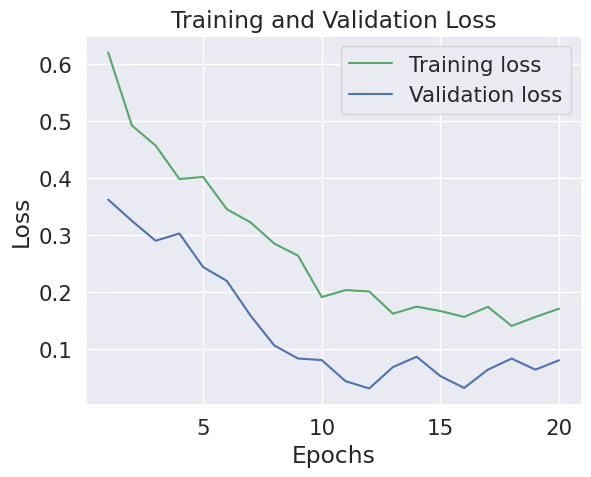

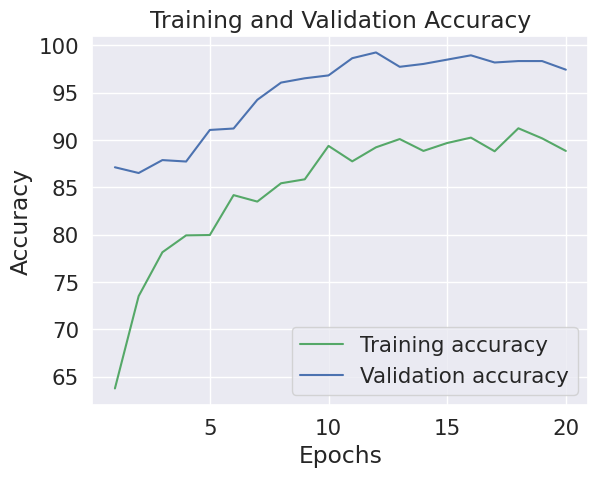

True positive =  297
False positive =  17
False negative =  0
True negative =  346




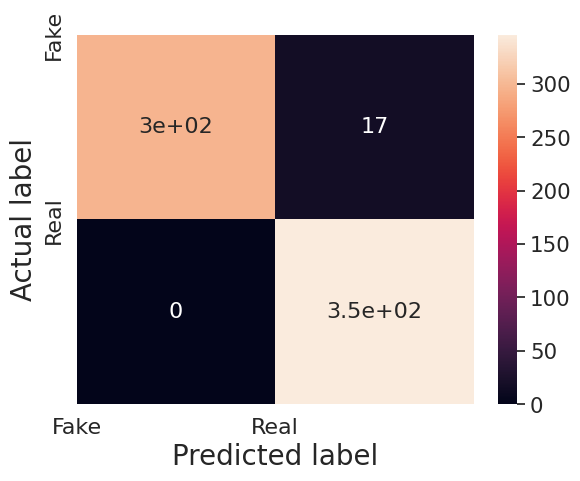

Calculated Accuracy 97.42424242424242
Precision: 0.953168044077135
Recall: 1.0
F1 Score: 0.9760225669957686


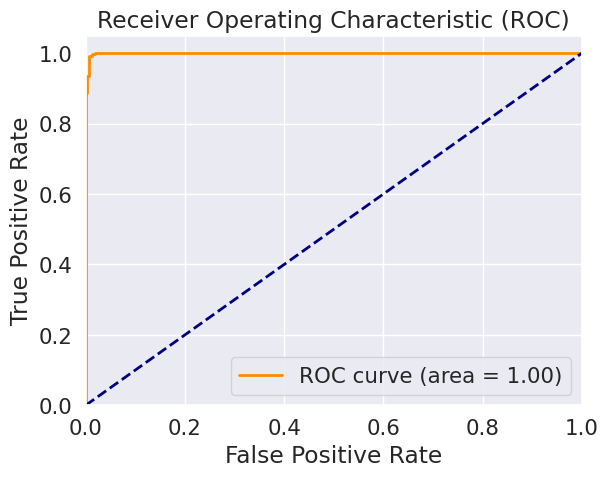

In [2]:
#!/usr/bin/env python
# coding: utf-8
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import cv2
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import sys

# Define the dataset class
class VideoDataset(Dataset):
    def __init__(self, video_names, labels, sequence_length=60, transform=None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.sequence_length = sequence_length
    
    def __len__(self):
        return len(self.video_names)
    
    def __getitem__(self, idx):
        video_path = self.video_names[idx]
        
        # Verify if label file exists and contains data
        if not os.path.exists(self.labels) or os.path.getsize(self.labels) == 0:
            raise FileNotFoundError("Labels file is empty or does not exist.")
        
        # Read labels data
        labels_df = pd.read_csv(self.labels, names=["file", "label"])
        
        # Handle empty labels or missing labels for a video
        try:
            label = labels_df.loc[labels_df['file'] == os.path.basename(video_path), 'label'].values[0]
            label = 0 if label == 'FAKE' else 1
        except IndexError:
            # Handle cases where no label is found for a video
            # You can choose to skip the video or assign a default label
            # Here, we'll raise an exception to indicate the issue
            raise ValueError(f"No label found for video: {video_path}")
        
        frames = []
        
        cap = cv2.VideoCapture(video_path)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_step = max(frame_count // self.sequence_length, 1)
        
        for i in range(0, frame_count, frame_step):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if ret:
                if self.transform:
                    frame = self.transform(frame)
                frames.append(frame)
            if len(frames) == self.sequence_length:
                break
        
        cap.release()
        frames = torch.stack(frames)
        return frames, label

import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, num_classes, latent_dim=2048, lstm_layers=1, hidden_dim=2048, bidirectional=True):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained=True)
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.swish = nn.SiLU()  # Swish activation function
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional=bidirectional)
        self.dropout = nn.Dropout(0.4)
        self.linear = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.swish(fmap)  # Apply Swish activation
        x = self.avgpool(x)
        x = x.view(batch_size, seq_length, -1)
        x_lstm, _ = self.lstm(x)
        return fmap, self.dropout(self.linear(torch.mean(x_lstm, dim=1)))


# Function to calculate accuracy
def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == targets).sum().item()
    return correct / batch_size * 100

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
    cm = confusion_matrix(y_true, y_pred_labels)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})
    plt.ylabel('Actual label', size=20)
    plt.xlabel('Predicted label', size=20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size=16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size=16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])
    print("Calculated Accuracy", calculated_acc * 100)


# Define the training function
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = []
    accuracies = []
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _, outputs = model(inputs)
        loss = criterion(outputs, targets)
        acc = calculate_accuracy(outputs, targets)
        losses.append(loss.item())
        accuracies.append(acc)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
            % (epoch, num_epochs, i, len(data_loader), np.mean(losses), np.mean(accuracies)))
    torch.save(model.state_dict(), 'checkpoint.pt')
    return np.mean(losses), np.mean(accuracies)

# Define the testing function
def test(epoch, model, data_loader, criterion):
    model.eval()
    losses = []
    accuracies = []
    true_labels = []
    predicted_probs = []  # Store predicted probabilities
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.LongTensor)
                inputs = inputs.cuda()
            _, outputs = model(inputs)
            loss = criterion(outputs, targets)
            acc = calculate_accuracy(outputs, targets)
            losses.append(loss.item())
            accuracies.append(acc)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(targets.cpu().numpy())
            predicted_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())  # Apply softmax
            sys.stdout.write(
                "\r[Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (i, len(data_loader), np.mean(losses), np.mean(accuracies)))
    print('\nAccuracy {}'.format(np.mean(accuracies)))
    return true_labels, predicted_probs, np.mean(losses), np.mean(accuracies)


# Set the paths to the data
fake_data_path = '/kaggle/input/deepfakedata/DFDC_FAKE_Face_only_data-20240320T124529Z-001/DFDC_FAKE_Face_only_data/'
ff_data_path = '/kaggle/input/deepfakedata/FF_Face_only_data-20240320T124139Z-001 2/FF_Face_only_data-20240320T124139Z-001.zip/'
real_data_path = '/kaggle/input/deepfakedata/DFDC_REAL_Face_only_data-20240320T124959Z-001/DFDC_REAL_Face_only_data/'
celeb_fake_path = '/kaggle/input/deepfakedata/Celeb_fake_face_only-20240320T123522Z-001/Celeb_fake_face_only/'
celeb_real_path = '/kaggle/input/deepfakedata/Celeb_real_face_only-20240320T123756Z-001/Celeb_real_face_only/'
labels_file_path = '/kaggle/input/deepfakedata/Gobal_metadata.csv'

# Split the data into train and validation sets
video_files = [fake_data_path, real_data_path]
train_videos, valid_videos = [], []

for path in video_files:
    videos = [path + file for file in os.listdir(path)]
    train, valid = train_test_split(videos, test_size=0.2)
    train_videos.extend(train)
    valid_videos.extend(valid)

# Define transformations
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

import random

def pad_tensors(data):
    """
    Pads tensors with zeros or discards them to ensure consistent shapes across a batch.

    Args:
        data: A list of tensors representing video sequences.

    Returns:
        A stacked tensor with padded or sampled video sequences.
    """

    # Determine maximum dimensions among tensors in the batch
    max_length = max(item.shape[0] for item in data)  # Max sequence length
    max_width = max(item.shape[2] for item in data)  # Max width
    max_height = max(item.shape[3] for item in data)  # Max height
    max_channels = max(item.shape[1] for item in data)  # Max channels

    # Pad or discard each tensor to match the maximum dimensions
    padded_data = []
    for item in data:
        pad_length = max_length - item.shape[0]
        pad_width = max_width - item.shape[2]
        pad_height = max_height - item.shape[3]
        pad_channels = max_channels - item.shape[1]

        # Pad the tensor with zeros
        padded_item = nn.functional.pad(item, (0, pad_channels, 0, pad_height, 0, pad_width, 0, pad_length), value=0)

        # Alternatively, discard tensors shorter than the maximum length
        # if item.shape[0] < max_length:
        #     continue

        padded_data.append(padded_item)

    return torch.stack(padded_data)

def custom_collate(batch):
    """
    Custom collate function that handles variable frame sizes.

    Args:
        batch: A list containing data and target pairs for each sample.

    Returns:
        A stacked tensor with padded or sampled video sequences, and a tensor of targets.
    """

    # Extract data and targets
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]

    # Choose between padding or discarding based on a flag
    padding_enabled = True  # Set to True for padding, False for discarding

    # Implement padding or discarding based on the chosen approach
    if padding_enabled:
        # Use pad_tensors function for padding
        return pad_tensors(data), torch.tensor(target)
    else:
        # Alternatively, discard tensors shorter than the maximum length
        processed_data = [(video, label) for video, label in zip(data, target) if video.shape[0] >= max_length]
        if processed_data:
            sampled_data, sampled_target = zip(*processed_data)
            return torch.stack(sampled_data), torch.tensor(sampled_target)
        else:
            # Return empty tensors if all videos are shorter than the maximum length
            return torch.tensor([]), torch.tensor([])  # Adjust as needed


# Create datasets
train_data = VideoDataset(train_videos, labels_file_path, transform=train_transforms)
valid_data = VideoDataset(valid_videos, labels_file_path, transform=train_transforms)


# Create datasets and data loaders with the custom collate function
train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=4, collate_fn=custom_collate)
valid_loader = DataLoader(valid_data, batch_size=4, shuffle=False, num_workers=4, collate_fn=custom_collate)



# Define the model, criterion, and optimizer
model = Model(2).cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

# Training loop
num_epochs = 20
train_loss_avg = []
train_accuracy = []
test_loss_avg = []
test_accuracy = []

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_epoch(epoch, num_epochs, train_loader, model, criterion, optimizer)
    train_loss_avg.append(train_loss)
    train_accuracy.append(train_acc)
    true_labels, predicted_labels, test_loss, test_acc = test(epoch, model, valid_loader, criterion)
    test_loss_avg.append(test_loss)
    test_accuracy.append(test_acc)

# Plot training and validation loss
plt.plot(range(1, num_epochs + 1), train_loss_avg, 'g', label='Training loss')
plt.plot(range(1, num_epochs + 1), test_loss_avg, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(range(1, num_epochs + 1), train_accuracy, 'g', label='Training accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Print confusion matrix
plot_confusion_matrix(true_labels, predicted_labels)

from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

def calculate_metrics(true_labels, predicted_probs):
    predicted_labels = np.argmax(predicted_probs, axis=1)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    return precision, recall, f1

def plot_roc_curve(true_labels, predicted_probs):
    predicted_probs = np.array(predicted_probs)  # Convert to NumPy array
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Calculate metrics
precision, recall, f1 = calculate_metrics(true_labels, predicted_labels)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot ROC curve
plot_roc_curve(true_labels, predicted_labels)
